In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from datetime import date
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

plt.style.use("seaborn-v0_8")


In [1]:
def predictive_logpdf(x, alpha_r, beta_r):
    """
    Log PDF of predictive Student-t for zero-mean model with unknown variance.
    """
    nu = 2 * alpha_r
    scale = np.sqrt(beta_r / alpha_r)
    return stats.t.logpdf(x, df=nu, loc=0, scale=scale)


class BOCPD:
    """
    Bayesian Online Changepoint Detection
    """

    def __init__(self, hazard_rate=1/30, alpha0=3.0, beta0=0.0007):
        self.h = hazard_rate
        self.alpha0 = alpha0
        self.beta0 = beta0

        # r_0 = 0 with prob 1
        self.run_length_probs = np.array([1.0])
        self.alpha = np.array([alpha0])
        self.beta = np.array([beta0])

    def update(self, x_t):
        R = len(self.run_length_probs)

        # 1) Predictive for continuation
        cont_logpdf = np.zeros(R)
        for r in range(R):
            cont_logpdf[r] = predictive_logpdf(x_t, self.alpha[r], self.beta[r])
        cont_pdf = np.exp(cont_logpdf)

        # Predictive for new segment (prior)
        new_pdf = np.exp(predictive_logpdf(x_t, self.alpha0, self.beta0))

        # 2) Unnormalised CP vs growth
        cp_unnorm = self.h * new_pdf * sum(self.run_length_probs[:-1])
        growth_unnorm = (1 - self.h) * self.run_length_probs * cont_pdf

        evidence = cp_unnorm + growth_unnorm.sum()
        cp_prob = cp_unnorm / evidence

        new_rl_probs = np.empty(R + 1)
        new_rl_probs[0] = cp_prob
        new_rl_probs[1:] = growth_unnorm / evidence

        # 3) Posterior updates
        new_alpha = np.empty(R + 1)
        new_beta = np.empty(R + 1)

        # r_t = 0 (new run)
        new_alpha[0] = self.alpha0 + 0.5
        new_beta[0] = self.beta0 + 0.5 * x_t**2

        # r_t > 0 (grown runs)
        new_alpha[1:] = self.alpha + 0.5
        new_beta[1:] = self.beta + 0.5 * x_t**2

        self.run_length_probs = new_rl_probs
        self.alpha = new_alpha
        self.beta = new_beta

        map_run_length = int(np.argmax(new_rl_probs))
        estimated_var = new_beta.mean() / (new_alpha.mean() - 1)

        return {
            "cp_prob": float(cp_prob),
            "map_run_length": map_run_length,
            "run_length_dist": new_rl_probs.copy(),
            "estimated_var": float(estimated_var),
        }


In [ ]:
def run_bocpd(returns, hazard_rate=1/30, alpha0=3.0, beta0=0.0007):
    """
    Run BOCPD over a 1D returns array and print first 5 steps.
    Forces each observation to a scalar float to avoid numpy
    DeprecationWarnings and formatting errors.
    """
    T = len(returns)
    bocpd = BOCPD(hazard_rate=hazard_rate, alpha0=alpha0, beta0=beta0)

    cp_probs = []
    est_vars = []
    map_rl = []
    rl_dists = []

    print("FIRST 5 STEPS:")
    print("-" * 60)

    for t in range(T):
        # ensure x_t is a scalar float, not a 0-d or 1-d array
        x_t = float(np.asarray(returns[t]))

        res = bocpd.update(x_t)

        cp_probs.append(res["cp_prob"])
        est_vars.append(res["estimated_var"])
        map_rl.append(res["map_run_length"])
        rl_dists.append(res["run_length_dist"])

        if t < 5:
            print(
                f"t={t:4d}  x={x_t:+.6f}  cp_prob={res['cp_prob']:.6f}  "
                f"MAP_RL={res['map_run_length']}"
            )

    cp_probs = np.array(cp_probs)
    est_vars = np.array(est_vars)
    map_rl = np.array(map_rl)

    print("\n... done processing series ...\n")
    print("=" * 70)
    print("CP PROBABILITY STATS")
    print("=" * 70)
    print(f"min:  {cp_probs.min():.6f}")
    print(f"max:  {cp_probs.max():.6f}")
    print(f"mean: {cp_probs.mean():.6f}")
    print()

    return cp_probs, est_vars, map_rl, rl_dists


In [ ]:
def plot_bocpd_results(returns, cp_probs, est_vars, map_rl, rl_dists, threshold=0.1):
    T = len(returns)
    x = np.arange(T)

    # detect changepoints by threshold
    changepoints = [i for i in range(5, T) if cp_probs[i] > threshold]

    fig, axes = plt.subplots(5, 1, figsize=(16, 14))

    # 1. Returns
    axes[0].plot(x, returns, linewidth=1, alpha=0.7)
    axes[0].set_title("Returns")
    axes[0].set_ylabel("r_t")

    # 2. CP prob full
    axes[1].plot(x, cp_probs, linewidth=1.2, label="P(r_t = 0)")
    axes[1].axhline(threshold, color="red", linestyle="--", label=f"threshold={threshold}")
    for cp in changepoints[:30]:
        axes[1].axvline(cp, color="black", linestyle=":", alpha=0.4)
    axes[1].set_title("Changepoint Probability")
    axes[1].set_ylabel("P(CP)")
    axes[1].legend()

    # 3. CP prob zoom on last N points
    zoom_window = 300 if T > 300 else T
    z0 = T - zoom_window
    axes[2].plot(np.arange(z0, T), cp_probs[z0:T], marker="o", markersize=3, linewidth=1.2)
    axes[2].axhline(threshold, color="red", linestyle="--")
    axes[2].set_title(f"Changepoint Probability (last {zoom_window} points)")
    axes[2].set_ylabel("P(CP)")
    axes[2].set_xlabel("Index")

    # 4. MAP run length
    axes[3].plot(x, map_rl, linewidth=1.2)
    axes[3].set_title("MAP Run Length")
    axes[3].set_ylabel("run length")

    # 5. Estimated variance
    axes[4].plot(x, est_vars, linewidth=1.2)
    axes[4].set_title("Estimated Variance")
    axes[4].set_ylabel("var")
    axes[4].set_xlabel("Index")

    plt.tight_layout()
    plt.show()


    print(f"Detected {len(changepoints)} changepoints with threshold {threshold}")
    print(changepoints)


In [ ]:
import numpy as np

def simulate_mc_data(T=2000, seed=42):
    """
    Simulate zero-mean Gaussian returns with multiple variance changepoints.

    """
    np.random.seed(seed)

    # Define true changepoints (1-based indices)
    changepoints = [250, 500, 800, 1100, 1400, 1600, 1800]

    # Corresponding standard deviations for each regime
    sigmas = [0.01, 0.04, 0.015, 0.06, 0.02, 0.05, 0.012, 0.03]

    # Build the piecewise signal
    returns = np.zeros(T)
    start = 0  # 0-based index

    for cp, sigma in zip(changepoints + [T], sigmas):
        end = cp  # this cp is 1-based; numpy slice end is end (exclusive) with 0-based index
        length = end - start
        returns[start:end] = np.random.normal(0.0, sigma, size=length)
        start = end

    return returns, changepoints

#data
returns, true_cps = simulate_mc_data()


FIRST 5 STEPS:
------------------------------------------------------------
t=   0  x=+0.004967  cp_prob=0.004000  MAP_RL=1
t=   1  x=-0.001383  cp_prob=0.003693  MAP_RL=2
t=   2  x=+0.006477  cp_prob=0.003470  MAP_RL=3
t=   3  x=+0.015230  cp_prob=0.003474  MAP_RL=4
t=   4  x=-0.002342  cp_prob=0.003154  MAP_RL=5

... done processing series ...

CP PROBABILITY STATS
min:  0.000536
max:  0.523788
mean: 0.004264



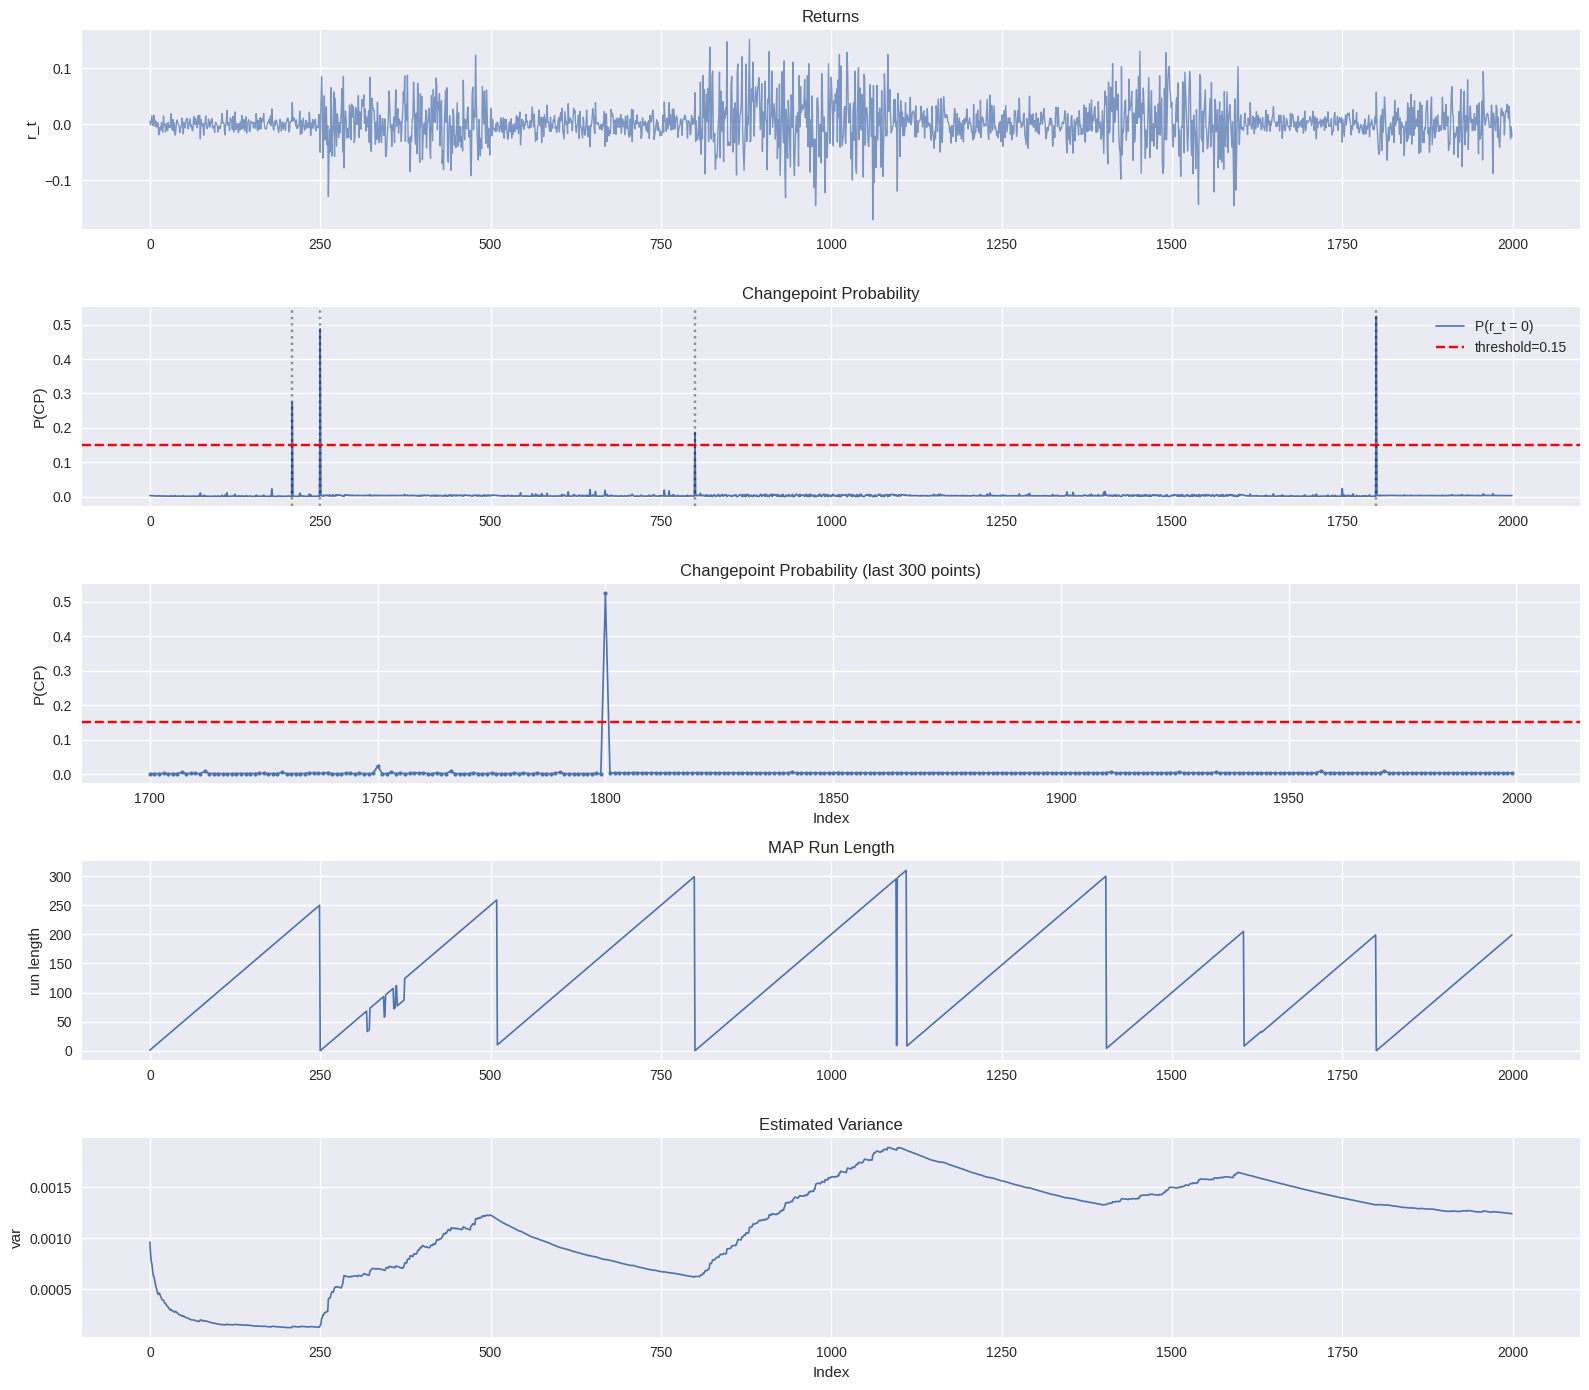

Detected 4 changepoints with threshold 0.15
First 20 indices: [209, 250, 800, 1800]


In [ ]:
hazard_rate = 1/250

alpha0 = 3

beta0 = (alpha0 - 1) * 0.0012

threshold = 0.15

# 2) Run BOCPD
cp_probs, est_vars, map_rl, rl_dists = run_bocpd(
    returns,
    hazard_rate=hazard_rate,
    alpha0=alpha0,
    beta0=beta0,
)

# 3) Plot & report
plot_bocpd_results(returns, cp_probs, est_vars, map_rl, rl_dists, threshold=threshold)


In [ ]:
class BOCPDEvaluator:
    """
    Evaluation using ground truth table
    """

    def __init__(self, true_changepoints, predictions, cp_probs, detection_delay_tolerance=50):
        self.true_cp = set(true_changepoints)
        self.pred_cp = set(predictions)
        self.cp_probs = np.array(cp_probs)
        self.T = len(cp_probs)
        self.tolerance = detection_delay_tolerance

    def detection_delay(self):
        delays = []
        for true_cp in sorted(self.true_cp):
            detected = [p for p in self.pred_cp if p >= true_cp]
            if detected:
                delays.append(min(detected) - true_cp)
            else:
                delays.append(np.inf)
        return delays

    def detection_metrics(self):
        TP = 0
        FP = 0
        matched_true = set()

        for pred in self.pred_cp:
            found = False
            for true_cp in self.true_cp:
                if abs(pred - true_cp) <= self.tolerance and true_cp not in matched_true:
                    TP += 1
                    matched_true.add(true_cp)
                    found = True
                    break
            if not found:
                FP += 1

        FN = len(self.true_cp) - len(matched_true)

        precision = TP / (TP + FP) if TP + FP > 0 else 0.0
        recall = TP / (TP + FN) if TP + FN > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0.0

        return {
            "TP": TP,
            "FP": FP,
            "FN": FN,
            "precision": precision,
            "recall": recall,
            "f1": f1,
        }

    def roc_metrics(self):
        y_true = np.zeros(self.T)
        for cp in self.true_cp:
            if cp < self.T:
                start = max(0, cp - self.tolerance)
                end = min(self.T, cp + self.tolerance + 1)
                y_true[start:end] = 1

        fpr, tpr, _ = roc_curve(y_true, self.cp_probs)
        roc_auc = auc(fpr, tpr)

        prec, rec, _ = precision_recall_curve(y_true, self.cp_probs)
        pr_auc = auc(rec, prec)

        return {
            "fpr": fpr,
            "tpr": tpr,
            "roc_auc": roc_auc,
            "precision": prec,
            "recall": rec,
            "pr_auc": pr_auc,
        }

    def generate_report(self):
        """Generate comprehensive evaluation report"""
        detection_metrics = self.detection_metrics()
        delays = self.detection_delay()
        roc_metrics = self.roc_metrics()

        report = {
            'Detection Performance': {
                'Precision': f"{detection_metrics['precision']:.4f}",
                'Recall': f"{detection_metrics['recall']:.4f}",
                'F1 Score': f"{detection_metrics['f1']:.4f}",
                'True Positives': detection_metrics['TP'],
                'False Positives': detection_metrics['FP'],
                'False Negatives': detection_metrics['FN']
            },
            'Timing Metrics': {
                'Mean Detection Delay': f"{np.mean([d for d in delays if d != np.inf]):.2f} steps" if any(d != np.inf for d in delays) else "N/A",
                'Median Detection Delay': f"{np.median([d for d in delays if d != np.inf]):.2f} steps" if any(d != np.inf for d in delays) else "N/A",
                'Max Detection Delay': f"{max([d for d in delays if d != np.inf]):.2f} steps" if any(d != np.inf for d in delays) else "N/A",
                'Missed Detections': sum(1 for d in delays if d == np.inf)
            },
            'ROC/AUC Metrics': {
                'ROC AUC': f"{roc_metrics['roc_auc']:.4f}",
                'Precision-Recall AUC': f"{roc_metrics['pr_auc']:.4f}"
            }
        }

        return report, roc_metrics


In [ ]:
# ==================== EVALUATION WITH GROUND TRUTH ====================
# Full ground-truth changepoint dates (2010–2025) converted to indices


true_changepoints = true_cps

print("TRUE CHANGEPOINT INDICES:")
print(true_changepoints)
print()



# ==================== DETECTED CHANGEPOINTS ====================

detected_changepoints = [i for i in range(5, len(cp_probs)) if cp_probs[i] > threshold]

print(f"Detected changepoints (threshold={threshold}): {len(detected_changepoints)}")
print(detected_changepoints)
print()

# ==================== EVALUATION ====================
evaluator = BOCPDEvaluator(
    true_changepoints=true_changepoints,
    predictions=detected_changepoints,
    cp_probs=cp_probs,
    detection_delay_tolerance=80   # realistic for daily data (≈ 3 months)
)

report, roc_metrics = evaluator.generate_report()

# Print report
print("="*80)
print("BOCPD MODEL EVALUATION REPORT")
print("="*80)
print()

for category, metrics in report.items():
    print(f"{category}:")
    print("-" * 80)
    for metric, value in metrics.items():
        print(f"  {metric:.<40} {value}")
    print()

print("="*80)
print(f"Detected Changepoints: {len(detected_changepoints)}")
print(f"Detection Delays: {evaluator.detection_delay()}")
print("="*80)


TRUE CHANGEPOINT INDICES:
[250, 500, 800, 1100, 1400, 1600, 1800]

Detected changepoints (threshold=0.15): 4
[209, 250, 800, 1800]

BOCPD MODEL EVALUATION REPORT

Detection Performance:
--------------------------------------------------------------------------------
  Precision............................... 0.7500
  Recall.................................. 0.4286
  F1 Score................................ 0.5455
  True Positives.......................... 3
  False Positives......................... 1
  False Negatives......................... 4

Timing Metrics:
--------------------------------------------------------------------------------
  Mean Detection Delay.................... 228.57 steps
  Median Detection Delay.................. 200.00 steps
  Max Detection Delay..................... 700.00 steps
  Missed Detections....................... 0

ROC/AUC Metrics:
--------------------------------------------------------------------------------
  ROC AUC.............................

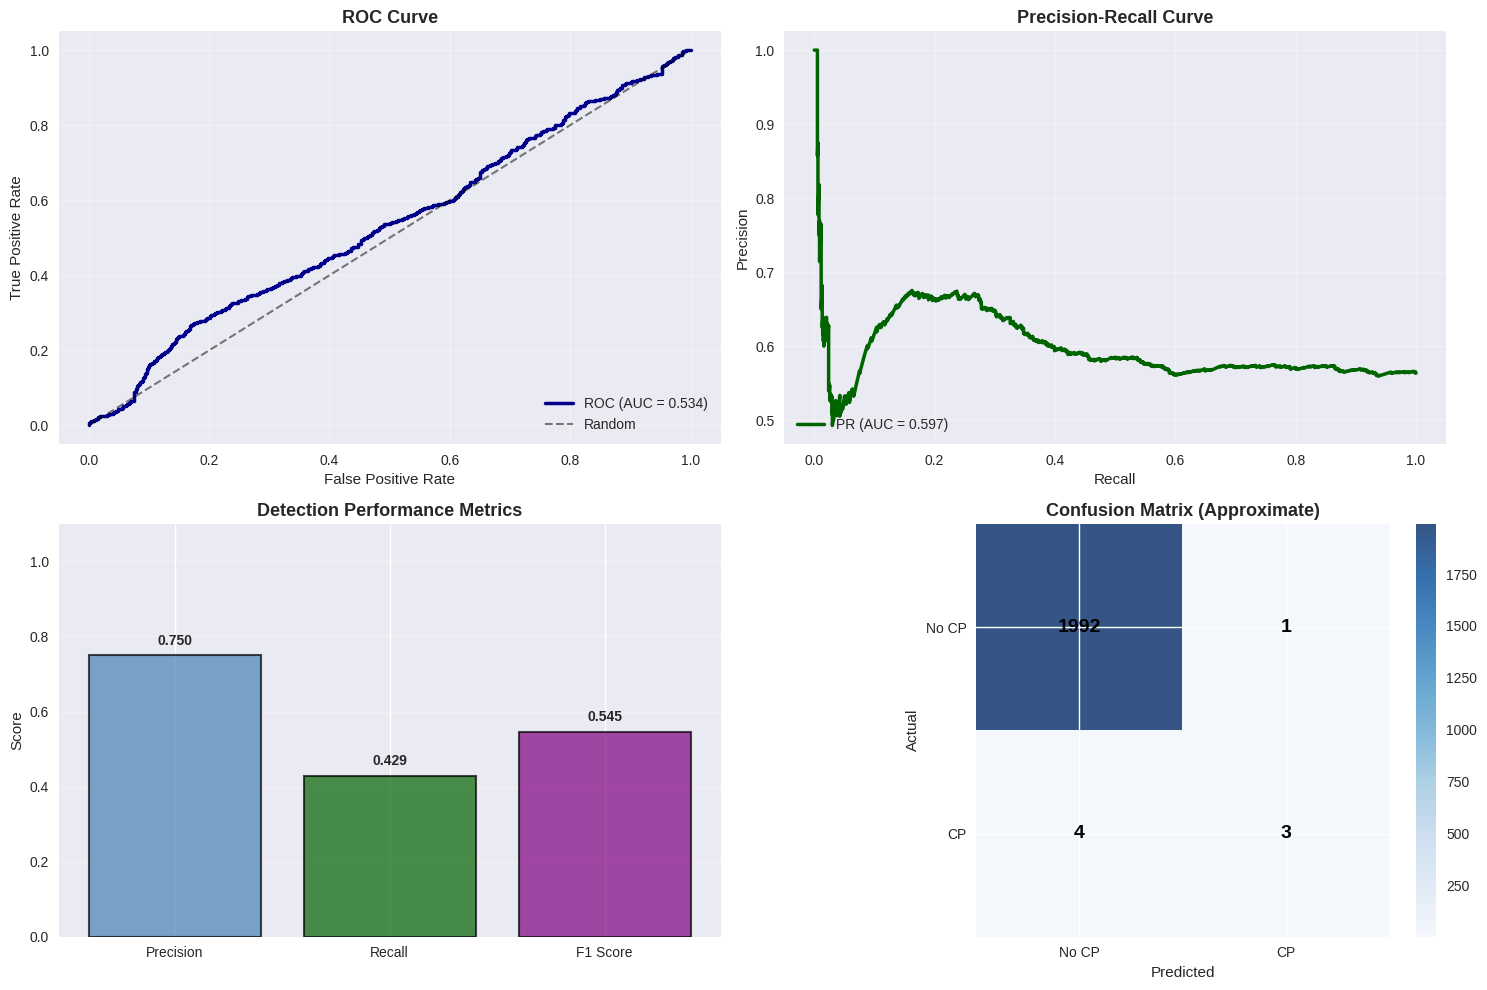


✓ Evaluation complete with visualizations


In [ ]:
# ==================== EVALUATION VISUALIZATIONS ====================
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. ROC Curve
axes[0, 0].plot(roc_metrics['fpr'], roc_metrics['tpr'],
                linewidth=2.5, color='darkblue', label=f"ROC (AUC = {roc_metrics['roc_auc']:.3f})")
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Random')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=11)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=11)
axes[0, 0].set_title('ROC Curve', fontsize=13, fontweight='bold')
axes[0, 0].legend(loc='lower right')
axes[0, 0].grid(alpha=0.3)

# 2. Precision-Recall Curve
axes[0, 1].plot(roc_metrics['recall'], roc_metrics['precision'],
                linewidth=2.5, color='darkgreen', label=f"PR (AUC = {roc_metrics['pr_auc']:.3f})")
axes[0, 1].set_xlabel('Recall', fontsize=11)
axes[0, 1].set_ylabel('Precision', fontsize=11)
axes[0, 1].set_title('Precision-Recall Curve', fontsize=13, fontweight='bold')
axes[0, 1].legend(loc='lower left')
axes[0, 1].grid(alpha=0.3)

# 3. Detection Performance Bar Chart
detection_perf = report['Detection Performance']
metrics_to_plot = ['Precision', 'Recall', 'F1 Score']
values = [float(detection_perf['Precision']),
          float(detection_perf['Recall']),
          float(detection_perf['F1 Score'])]
colors = ['steelblue', 'darkgreen', 'purple']
bars = axes[1, 0].bar(metrics_to_plot, values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('Score', fontsize=11)
axes[1, 0].set_title('Detection Performance Metrics', fontsize=13, fontweight='bold')
axes[1, 0].set_ylim([0, 1.1])
axes[1, 0].grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Confusion Matrix Visualization
TP = detection_perf['True Positives']
FP = detection_perf['False Positives']
FN = detection_perf['False Negatives']
TN = len(cp_probs) - TP - FP - FN  # Approximate

conf_matrix = np.array([[TN, FP], [FN, TP]])
im = axes[1, 1].imshow(conf_matrix, cmap='Blues', alpha=0.8)

axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_yticks([0, 1])
axes[1, 1].set_xticklabels(['No CP', 'CP'])
axes[1, 1].set_yticklabels(['No CP', 'CP'])
axes[1, 1].set_xlabel('Predicted', fontsize=11)
axes[1, 1].set_ylabel('Actual', fontsize=11)
axes[1, 1].set_title('Confusion Matrix (Approximate)', fontsize=13, fontweight='bold')

for i in range(2):
    for j in range(2):
        text = axes[1, 1].text(j, i, conf_matrix[i, j],
                              ha="center", va="center", color="black",
                              fontsize=14, fontweight='bold')

plt.colorbar(im, ax=axes[1, 1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print("\n✓ Evaluation complete with visualizations")
